# Predicting Games Rating Score

In this project we are applying machine learning algorithms to predicts VGChartz rating scores for games. To achinve the best result possible we need to pick the best model that fit the data. The algorithms that we are planning to use are Linear Rigresson, Lasso and Ridge.

## Imporing Libraries

In [1]:
from utilities.VGChartz import get_games_data
import seaborn as sns
sns.set_style("darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from rich import print
import pandas as pd
import numpy as np
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model


from sklearn.linear_model import Lasso, Ridge, ElasticNet,LassoCV,RidgeCV

from sklearn.model_selection import cross_val_score, train_test_split,KFold, GridSearchCV


## Get VGChartz data 
by calling `get_games_data` which scrap the data from VGChartz if the `/data/VGChartz.csv` file is not exsist.

In [2]:
df = get_games_data()
df_ratings = pd.read_csv('data/Video_Games_Sales_as_at_22_Dec_2016.csv')

In [3]:
df['Game'] = [x.split('    Read the review')[0] for x in df['Game']]

In [4]:
df_ratings.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.Game[0]

'Super Mario Galaxy'

In [6]:
df_ratings[df_ratings['Name'] == 'Super Mario Galaxy']

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
49,Super Mario Galaxy,Wii,2007.0,Platform,Nintendo,6.06,3.35,1.2,0.74,11.35,97.0,73.0,8.9,2147.0,Nintendo,E


In [7]:
df[df['Game'] == 'Super Mario Galaxy']

,ID,Game,Genre,Console,Publisher,Developer,VGChartz Score,Critic Score,User Score,Total Shipped,Total Sales,NA Sales,PAL Sales,Japan Sales,Other Sales,Release Date,Last Update
0,6963,Super Mario Galaxy,Platform,Wii,Nintendo,Nintendo EAD Tokyo,9.6,9.7,9.6,12.80m,NaN,NaN,NaN,NaN,NaN,12th Nov 07,NaN


In [8]:
x = df.merge(df_ratings[['Rating', 'Year_of_Release', 'User_Count',
                         'Critic_Count', 'Global_Sales', 'Name', 'Platform']], 
         left_on=['Game', 'Console'],
         right_on=['Name', 'Platform'])

In [9]:
new_df = x.dropna(subset=['Rating'])[['ID', 'Name', 'Genre', 'Console', 'Rating', 'Global_Sales', 'VGChartz Score', 'Critic Score', 'Critic_Count', 'User Score', 'User_Count', 'Release Date']]


## Cleaning VGChartz Data

In [10]:
# Creating new Feature called Score by taking the average of the three type of scores
temp = new_df[['VGChartz Score', 'Critic Score', 'User Score']]
temp=temp.T.fillna(temp.T.mean()).T
new_df[['VGChartz Score', 'Critic Score', 'User Score']] = temp
new_df['Score'] = (new_df['VGChartz Score'] +new_df['Critic Score'] + new_df['User Score'])/3
new_df =new_df.dropna(subset=['Score'])
new_df['User_Count'] = new_df['User_Count'].fillna(new_df['User_Count'].mean())
new_df['Critic_Count'] = new_df['Critic_Count'].fillna(new_df['Critic_Count'].mean())

In [11]:
new_df['Release Date'] = [int(x.split(' ')[-1]) +2000 for x in new_df['Release Date']]
new_df['Global_Sales'] = new_df['Global_Sales'] * 10**3

In [12]:
new_df['Release Date'] = new_df['Release Date'] -new_df['Release Date'].min()

In [13]:
new_df['Global_Sales'].min()

20.0

In [14]:
new_df = new_df.loc[:, (new_df.columns != 'Unnamed: 0')]

In [15]:
new_df

,ID,Name,Genre,Console,Rating,Global_Sales,VGChartz Score,Critic Score,Critic_Count,User Score,User_Count,Release Date,Score
0,6963,Super Mario Galaxy,Platform,Wii,E,11350.0,9.6,9.7,73.0,9.60,2147.0,6,9.633333
1,35084,Super Mario Galaxy 2,Platform,Wii,E,7510.0,9.6,9.7,87.0,9.80,1854.0,9,9.700000
2,6970,Metal Gear Solid 4: Guns of the Patriots,Action,PS3,M,5990.0,9.5,9.3,82.0,9.80,3558.0,7,9.533333
3,17684,World of Goo,Puzzle,PC,E,40.0,9.5,9.0,26.0,9.25,607.0,7,9.250000
4,12533,God of War III,Action,PS3,M,4800.0,9.4,9.2,101.0,9.40,2633.0,9,9.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
427,23754,Velvet Assassin,Shooter,X360,M,180.0,3.2,5.3,46.0,4.25,55.0,8,4.250000
428,24538,Stormrise,Strategy,PC,M,20.0,3.1,3.1,15.0,3.10,22.0,8,3.100000
429,17668,NCAA Football 09 All-Play,Sports,Wii,E,160.0,3.0,5.3,5.0,4.15,32.0,7,4.150000
430,14604,Golden Axe: Beast Rider,Action,PS3,M,320.0,4.5,4.5,30.0,4.50,23.0,7,4.500000


In [16]:
new_df = new_df.loc[:, (new_df.columns != 'User Score')]


In [17]:
new_df = new_df.loc[:, (new_df.columns != 'Critic Score')]


In [18]:
new_df = new_df.loc[:, (new_df.columns != 'VGChartz Score')]


In [48]:
new_df.Rating.unique()

array(['E', 'M', 'T', 'E10+'], dtype=object)

In [20]:
new_df.Console.unique()

array(['Wii', 'PS3', 'PC', 'PS2', 'X360', 'DS', 'GC', 'PSP', 'XOne',
       'PSV', '3DS'], dtype=object)

In [21]:
new_df.Genre.unique()

array(['Platform', 'Action', 'Puzzle', 'Adventure', 'Role-Playing',
       'Shooter', 'Racing', 'Misc', 'Fighting', 'Sports', 'Strategy',
       'Music', 'Simulation', 'Action-Adventure', 'Party'], dtype=object)

## Spliting Features for testing the corralation

In [32]:
new_df = new_df.loc[:, (new_df.columns != 'ID')]
new_df = new_df.loc[:, (new_df.columns != 'Name')]
new_df.head(1)

,Genre,Console,Rating,Global_Sales,Critic_Count,User_Count,Release Date,Score
0,Platform,Wii,E,11350.0,73.0,2147.0,6,9.633333


In [33]:
new_df.corr()

,Global_Sales,Critic_Count,User_Count,Release Date,Score
Global_Sales,1.000000,0.351410,0.314267,-0.091466,0.237868
Critic_Count,0.351410,1.000000,0.476351,0.001368,0.506399
User_Count,0.314267,0.476351,1.000000,0.017446,0.364064
Release Date,-0.091466,0.001368,0.017446,1.000000,-0.128027
Score,0.237868,0.506399,0.364064,-0.128027,1.000000


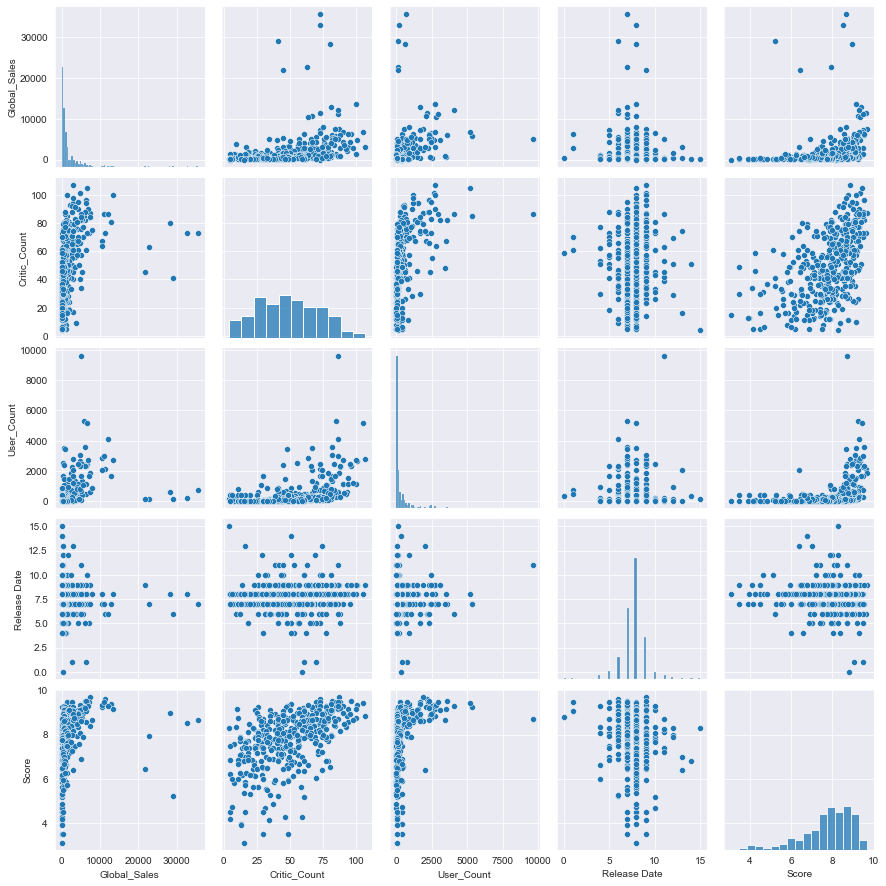

In [34]:
sns.pairplot(new_df)

In [35]:
new_df.head(1)

,Genre,Console,Rating,Global_Sales,Critic_Count,User_Count,Release Date,Score
0,Platform,Wii,E,11350.0,73.0,2147.0,6,9.633333


In [36]:
big_new_df = new_df.copy()

big_new_df = big_new_df.loc[:, (big_new_df.columns != 'Genre')]
big_new_df = big_new_df.loc[:, (big_new_df.columns != 'Console')]
big_new_df = big_new_df.loc[:, (big_new_df.columns != 'Rating')]

big_new_df_Genre1 = pd.get_dummies(new_df['Genre'], columns=['Genre'])
big_new_df_Genre = pd.concat([big_new_df, big_new_df_Genre1], axis=1)

big_new_df_Rating1 = pd.get_dummies(new_df['Rating'], columns=['Rating'])
big_new_df_Rating = pd.concat([big_new_df, big_new_df_Rating1], axis=1)


big_new_df_Console1 = pd.get_dummies(new_df['Console'], columns=['Console'])
big_new_df_Console = pd.concat([big_new_df, big_new_df_Console1], axis=1)


big_new_df_Genre_Console1 = pd.get_dummies(new_df[['Genre','Console']], columns=['Genre','Console'])
big_new_df_Genre_Console = pd.concat([big_new_df, big_new_df_Genre_Console1], axis=1)


big_new_df_Genre_Rating1 = pd.get_dummies(new_df[['Genre','Rating']], columns=['Genre','Rating'])
big_new_df_Genre_Rating = pd.concat([big_new_df, big_new_df_Genre_Rating1], axis=1)


big_new_df_Console_Rating1 = pd.get_dummies(new_df[['Console','Rating']], columns=['Console','Rating'])
big_new_df_Console_Rating = pd.concat([big_new_df, big_new_df_Console_Rating1], axis=1)


big_new_df_Genre_Console_Rating = pd.get_dummies(new_df, columns=['Genre','Console','Rating'])

#big_new_df = new_df.copy()


In [37]:
big_new_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 399 entries, 0 to 431
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Global_Sales  399 non-null    float64
 1   Critic_Count  399 non-null    float64
 2   User_Count    399 non-null    float64
 3   Release Date  399 non-null    int64  
 4   Score         399 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 34.9 KB


<AxesSubplot:ylabel='Critic_Count'>

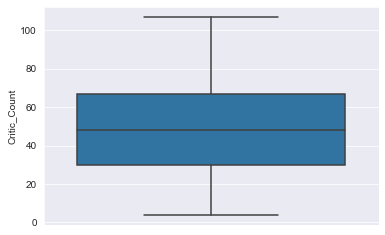

In [38]:
sns.boxplot(y=big_new_df['Critic_Count'])

## Creating Models

In [39]:
def linear_regression_score(X_train, y_train, X_test, y_test):
    lr = LinearRegression()
    lr.fit(X_train, y_train)
    r2 = lr.score(X_test, y_test)
    return r2

def lasso_score(X_train, y_train, X_test, y_test):
    clf = linear_model.Lasso(alpha=0.1)
    clf.fit(X_train, y_train)
    r2 = clf.score(X_test, y_test)
    return r2
    
def riggid_score(X_train, y_train, X_test, y_test):
    clf = Ridge(alpha=1.0)
    clf.fit(X_train, y_train)
    r2 = clf.score(X_test, y_test)
    return r2


### Find the $R^2$ score for all models

In [40]:
def find_scores(df, target:str):
    df_X = df[df.columns.difference([target])]
    df_y = df[target]
    X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.33, random_state=1024 ,shuffle=True) 
    
    linear_score = linear_regression_score(X_train, y_train, X_test, y_test)
    lassov_score = lasso_score(X_train, y_train, X_test, y_test)
    riggidv_score = riggid_score(X_train, y_train, X_test, y_test)    
    return {'Linear Score':linear_score,'Lasso Score':lassov_score,'Ridge Score':riggidv_score}


In [41]:
a = pd.DataFrame(
    {
        'No Categorical':find_scores(big_new_df, 'Global_Sales'),
        'Genre':find_scores(big_new_df_Genre, 'Global_Sales'),
        'Console':find_scores(big_new_df_Console, 'Global_Sales'),
        'Rating':find_scores(big_new_df_Rating, 'Global_Sales'),
        'Console & Rating':find_scores(big_new_df_Console_Rating, 'Global_Sales'),
        'Genre & Console':find_scores(big_new_df_Genre_Console, 'Global_Sales'),
        'Genre & Rating':find_scores(big_new_df_Genre_Rating, 'Global_Sales'),
        'All Categorical':find_scores(big_new_df_Genre_Console_Rating, 'Global_Sales')
    }
)

C:\Users\pspso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 7.674e+07, tolerance: 3.883e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\pspso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.802e+07, tolerance: 3.883e+05
  model = cd_fast.enet_coordinate_descent(
C:\Users\pspso\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:645: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale 

In [42]:
a.T

,Linear Score,Lasso Score,Ridge Score
No Categorical,0.172062,0.172069,0.172088
Genre,0.160681,0.160806,0.163956
Console,0.242307,0.242381,0.244139
Rating,0.240552,0.240547,0.240355
Console & Rating,0.302434,0.302504,0.304803
Genre & Console,0.221529,0.222290,0.233919
Genre & Rating,0.193233,0.193353,0.198735
All Categorical,0.236200,0.236593,0.253576


In [43]:
big_new_df.head(1)

,Global_Sales,Critic_Count,User_Count,Release Date,Score
0,11350.0,73.0,2147.0,6,9.633333


In [50]:
a.keys()

Index(['No Categorical', 'Genre', 'Console', 'Rating', 'Console & Rating',
       'Genre & Console', 'Genre & Rating', 'All Categorical'],
      dtype='object')